# Train Model

In [1]:
import sys
import os

# Detect Google Colab
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Detect Google Colab
if "google.colab" in sys.modules:
    print("Running in Google Colab...")
    os.system("git clone https://github.com/CiaranMaloy/audioautoencoder")
    os.chdir("/content/audioautoencoder/")
    os.system("git pull")
    os.system("git checkout bandchannels")
    os.system("git pull origin bandchannels")
    #os.system("pip install --upgrade torchmetrics")
else:
    print("Running locally...")
    os.system("git pull origin bandchannels")
    #os.system("pip install --upgrade torchmetrics")


Running in Google Colab...


In [3]:
import sys
sys.path.append('/content/audioautoencoder')
sys.path.append('/content/audioautoencoder/audioautoencoder')

## Define Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import math

## Masking Unet
# enhanced attention on skip connections
# deep 3 headded self attention in bottleneck
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None, None]

class ResBlock(nn.Module):
    def __init__(self, channels:int, num_groups:int, dropout_prob:float, kernel_size=3):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=channels)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=channels)

        # Adding proper padding calculation to maintain spatial dimensions
        padding = kernel_size // 2 if isinstance(kernel_size, int) else (kernel_size[0] // 2, kernel_size[1] // 2)

        self.conv1 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=padding)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))  # Fixed: use r instead of x for the second conv
        return r + x

class Attention(nn.Module):
    def __init__(self, channels: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(channels, channels*3)
        self.proj2 = nn.Linear(channels, channels)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')


class ResLayer(nn.Module):
    def __init__(self, channels, kernel_size=3, attention=False, num_groups=16, dropout_prob=0.1, num_heads=8, upscale=False, downscale=False):
        super().__init__()
        self.upscale = upscale
        self.downscale = downscale

        # Calculate proper padding
        padding = kernel_size // 2 if isinstance(kernel_size, int) else (kernel_size[0] // 2, kernel_size[1] // 2)

        self.ResBlock1 = ResBlock(channels=channels, kernel_size=kernel_size, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(channels=channels, kernel_size=kernel_size, num_groups=num_groups, dropout_prob=dropout_prob)

        if upscale:
            self.conv = nn.ConvTranspose2d(channels, channels // 2, kernel_size=2, stride=2, padding=0)
        elif downscale:
            self.conv = nn.Conv2d(channels, channels * 2, kernel_size=3, stride=2, padding=1)

        if attention:
            self.attention_layer = Attention(channels, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)

        if self.upscale:
            x = self.conv(x)
        elif self.downscale:
            x = self.conv(x)

        return x

class EnhancedSkipAttention(nn.Module):
    def __init__(self, encoder_channels, decoder_channels, reduction_ratio=4):
        super().__init__()
        self.channels = encoder_channels

        # Channel attention for encoder features
        self.encoder_channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(encoder_channels, encoder_channels // reduction_ratio, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(encoder_channels // reduction_ratio, encoder_channels, kernel_size=1),
            nn.Sigmoid()
        )

        # Projection for decoder features to match encoder dimensions if needed
        self.decoder_proj = None
        if encoder_channels != decoder_channels:
            self.decoder_proj = nn.Conv2d(decoder_channels, encoder_channels, kernel_size=1)

        # Cross-attention between encoder and decoder features
        self.cross_attn = nn.Sequential(
            nn.Conv2d(encoder_channels*2, 2, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, encoder_features, decoder_features):
        # Process decoder features if dimensions don't match
        if self.decoder_proj is not None:
            decoder_features = self.decoder_proj(decoder_features)

        # Apply channel attention to encoder features
        channel_attn = self.encoder_channel_attn(encoder_features)
        encoder_features = encoder_features * channel_attn

        # Concatenate encoder and decoder features
        combined = torch.cat([encoder_features, decoder_features], dim=1)

        # Generate attention weights for each feature set
        attn_weights = self.cross_attn(combined)
        encoder_weight, decoder_weight = torch.split(attn_weights, 1, dim=1)

        # Apply weights and combine features
        result = encoder_features * encoder_weight + decoder_features * decoder_weight

        return result

class UNetConv11(nn.Module):
    # Update from UnetConv6, moving to a masking model, which hopefully works better
    def __init__(self, in_channels=9, out_channels=4, time_steps=1000):
        super().__init__()

        channels = 64

        # Fixed input layer with proper padding calculation for given kernel size
        self.sigmoid = nn.Sigmoid()
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels, channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Encoder (Downsampling) - using standard kernel sizes with proper padding
        self.enc1 = ResLayer(channels, kernel_size=3, downscale=True)
        self.enc2 = ResLayer(channels * 2, kernel_size=3, downscale=True)
        self.enc3 = ResLayer(channels * 4, kernel_size=3, downscale=True)
        self.enc4 = ResLayer(channels * 8, kernel_size=3, downscale=True)

        # Bottleneck
        self.bottleneck_in = ResLayer(channels * 16, kernel_size=3)
        self.resattention = ResLayer(channels * 16, kernel_size=3, attention=True)
        self.bottleneck_out = ResLayer(channels * 16, kernel_size=3)

        # Decoder (Upsampling) - using standard kernel sizes
        self.dec4 = ResLayer(channels * 16, kernel_size=3, upscale=True)
        self.dec3 = ResLayer(channels * 8, kernel_size=3, upscale=True)
        self.dec2 = ResLayer(channels * 4, kernel_size=3, upscale=True)
        self.dec1 = ResLayer(channels * 2, kernel_size=3, upscale=True)

        # Final output layer
        self.output_layer = nn.Sequential(
            nn.Conv2d(channels, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        # Initialize Spatial Attention Modules
        self.attn4 = EnhancedSkipAttention(channels * 16, channels * 16)
        self.attn3 = EnhancedSkipAttention(channels * 8, channels * 8)
        self.attn2 = EnhancedSkipAttention(channels * 4, channels * 4)
        self.attn1 = EnhancedSkipAttention(channels * 2, channels * 2)

        # embeddings
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=channels * 16)

    def forward(self, x, t=0):
        """Forward pass with skip connections"""
        input_shape = x.shape[2:]  # Remember original input spatial dimensions
        embeddings = self.embeddings(x, t)

        # Encoding
        input_features = self.input_layer(x)
        e1 = self.enc1(input_features, embeddings)
        e2 = self.enc2(e1, embeddings)
        e3 = self.enc3(e2, embeddings)
        e4 = self.enc4(e3, embeddings)

        # Bottleneck
        b = self.bottleneck_in(e4, embeddings)
        b = self.resattention(b, embeddings)
        b = self.bottleneck_out(b, embeddings)

        # Decoding with proper feature alignment
        # For decoder stage 4
        b = F.interpolate(b, size=e4.shape[2:], mode="bilinear", align_corners=False)
        d4 = self.attn4(e4, b)
        d4 = self.dec4(d4, embeddings)

        # For decoder stage 3
        d4 = F.interpolate(d4, size=e3.shape[2:], mode="bilinear", align_corners=False)
        d3 = self.attn3(e3, d4)
        d3 = self.dec3(d3, embeddings)

        # For decoder stage 2
        d3 = F.interpolate(d3, size=e2.shape[2:], mode="bilinear", align_corners=False)
        d2 = self.attn2(e2, d3)
        d2 = self.dec2(d2, embeddings)

        # For decoder stage 1
        d2 = F.interpolate(d2, size=e1.shape[2:], mode="bilinear", align_corners=False)
        d1 = self.attn1(e1, d2)
        d1 = self.dec1(d1, embeddings)

        # Final output with bilinear interpolation to match input size
        mask = self.output_layer(d1)
        mask = F.interpolate(mask, size=input_shape, mode="bilinear", align_corners=False)

        # Apply mask to the first 4 channels of input
        return mask

## Test Model

In [5]:
BATCH_SIZE = 1
t = torch.randint(0, 1000, (BATCH_SIZE,))
TEST_MODEL = True

if TEST_MODEL:
  if __name__ == "__main__":
      x = torch.randn((BATCH_SIZE, 9, 1025, 175))
      model = UNetConv11()
      output = model(x, t)

      print('output....')
      print(output.shape)

output....
torch.Size([1, 4, 1025, 175])


In [6]:
import unittest
import torch
from torchsummary import summary

class TestAutoencoder(unittest.TestCase):
    def setUp(self):
        self.model = UNetConv11()
        self.input_channels = 9
        self.output_channels = 4
        self.input_height = 1025
        self.input_width = 175
        self.batch_size = BATCH_SIZE
        self.t = torch.randint(0, 1000, (BATCH_SIZE,))
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def test_model_initialization(self):
        self.assertIsInstance(self.model, UNetConv11, "Model initialization failed")

    def test_forward_pass(self):
        x = torch.randn(self.batch_size, self.input_channels, self.input_height, self.input_width, device=self.device)
        output = self.model(x, self.t)
        self.assertEqual(
            output.shape,
            (self.batch_size, self.output_channels, self.input_height, self.input_width),
            f"Expected output shape {(self.batch_size, self.output_channels, self.input_height, self.input_width)}, but got {output.shape}"
        )

    def test_model_summary(self):
        try:
            summary(self.model, input_size=(self.input_channels, self.input_height, self.input_width))
        except Exception as e:
            self.fail(f"Model summary failed: {str(e)}")

# This allows running tests externally
def suite():
    test_suite = unittest.TestLoader().loadTestsFromTestCase(TestAutoencoder)
    return test_suite

# runner
class TestRunner:
    def __init__(self):
        self.runner = unittest.TextTestRunner()

    def run(self):
        print("Running autoencoder tests...")
        self.runner.run(suite())

if TEST_MODEL:
  if __name__ == "__main__":
      runner = TestRunner()
      runner.run()

Running autoencoder tests...


..F
FAIL: test_model_summary (__main__.TestAutoencoder.test_model_summary)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-6-ecf76d946c7e>", line 31, in test_model_summary
    summary(self.model, input_size=(self.input_channels, self.input_height, self.input_width))
  File "/usr/local/lib/python3.11/dist-packages/torchsummary/torchsummary.py", line 72, in summary
    model(*x)
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-4-4d0450a44b0b>", line 197, in forward
    embeddings = self.embeddings(x, t)
                 ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loca

## Define Params

In [7]:
from audioautoencoder.plotting import *
from audioautoencoder.datasets.utils import *
#from audioautoencoder.models.UNetConv10mask import *
# Instantiate the model, define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetConv11().to(device)

print(device)

cpu


In [8]:
i = 0
train = True
LOAD_DATA = True
load_model = False

# --------------- Main Execution parameters ---------------
model_name = 'UNetConv11_diffusion'
train_diffusion = True
SNRdB_load = [-10, 10]
SNRdBs = [[-10, 10]] # SNR random range
load_trigger = [load_model]
load_file = 'Autoencodermodel_earlystopping.pth'
#load_file = 'Autoencodermodel_checkpoint.pth'

folder = ['sep_features', 'all-noise_features'][1] # sep

# parameters
learning_rates = [1e-3] # 1e-4 for re0training?, 1e-3 for training?

base_lr=1e-5
max_lr=learning_rates[i]
gamma=0.8

# data params
max_file_size_gb = 10
IMPORT_TRAIN_NOISY = train
batch_size = 16

# training params
load = load_trigger[i]
warm_start = False
epochs = 30
accumulation_steps = int(512/batch_size)

SNRdB = SNRdBs[i]
learning_rate = learning_rates[i]
eta_min = 1e-5

print('lr:', learning_rate)
print('SNRdB:', SNRdB)

lr: 0.001
SNRdB: [-10, 10]


In [9]:
# --------------- In Loop Parameters --------------
output_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_{model_name}_{SNRdB[0]}-{SNRdB[1]}/'
load_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/{load_file}'

## Load Data

In [10]:
import os
import joblib  # or use pickle if you prefer

def save_scalers(scalers, save_path):
    """Save scalers to a file."""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(scalers, save_path)

def load_scalers(save_path):
    """Load scalers from a file."""
    return joblib.load(save_path)

In [11]:
from audioautoencoder.datasets.utils import *
from audioautoencoder.data import *
from audioautoencoder.data_management import *
from audioautoencoder.generate_dataset import *

In [12]:
# Define the source and destination file paths
if LOAD_DATA:
  scaler_file = output_path + "scalers.pkl"  # Static filename since it's unique per run
  source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_{folder}/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
  source_path = source_folder + "train/"
  destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/"
  save_path = source_folder + "combined_000.h5"
  subset = False

  if IMPORT_TRAIN_NOISY:
    dataset_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/combined_000.h5"
    if not os.path.exists(destination_path):
      combine_h5_files_features(source_path, destination_path, max_file_size_gb=max_file_size_gb)

    if os.path.exists(scaler_file):
        print("Loading existing scalers...")
        scalers = load_scalers(scaler_file)
    else:
        print("Training new scalers...")
        scalers = train_scalers_separation(dataset_path, sample_size=8000)
        save_scalers(scalers, scaler_file)

    print(scalers)

    train_loader = DiffusionDatasetLoader(
          dataset_path=dataset_path,
          scalers=scalers,
          output_time_length=175,
          channels=1,
          snr_db=SNRdB,
          subset=subset,
          batch_size=batch_size
      )

    print(f"Training set size: {len(train_loader.train_dataset)}")
    print(f"Validation set size: {len(train_loader.val_dataset)}")

Created new file: /content/SNRdB_-10-10/train/combined_000.h5
Progress: 1.33 GB - Processing /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_all-noise_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250310_092117.h5
Progress: 2.18 GB - Processing /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_all-noise_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250310_093522.h5
Progress: 3.07 GB - Processing /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_all-noise_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250310_093522.h5
Progress: 4.36 GB - Processing /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_all-noise_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250310_093812.h5
Progress: 5.2 GB - Processing /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_all-noise_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250310_093812.h5
Progress: 6.09 GB - Processing /content/drive/MyDrive/Datasets/Music-Noise/SNRdB_all-noise_features/SNRdB_-10-10/train/train-SNRdB_-10-10_20250310_094150.

## Inspect Data

In [13]:
if LOAD_DATA:
  input, output, medatata = train_loader.train_dataset[200]
  print(input.shape)
  print(output.shape)

torch.Size([9, 1025, 175])
torch.Size([4, 1025, 175])


-0.523464024066925
Min, Max:  0.0 1.0
Min, Max:  0.0 1.0
Min, Max:  0.0 1.0
Min, Max:  0.0 1.0
Min, Max:  0.0 1.0
Min, Max:  0.0 1.0
Min, Max:  0.0 1.0
Min, Max:  0.0 1.0
Min, Max:  0.0 1.0
Min, Max:  0.0 1.0
Min, Max:  0.0 1.0
Min, Max:  0.0 1.0
Min, Max:  0.0 0.98764


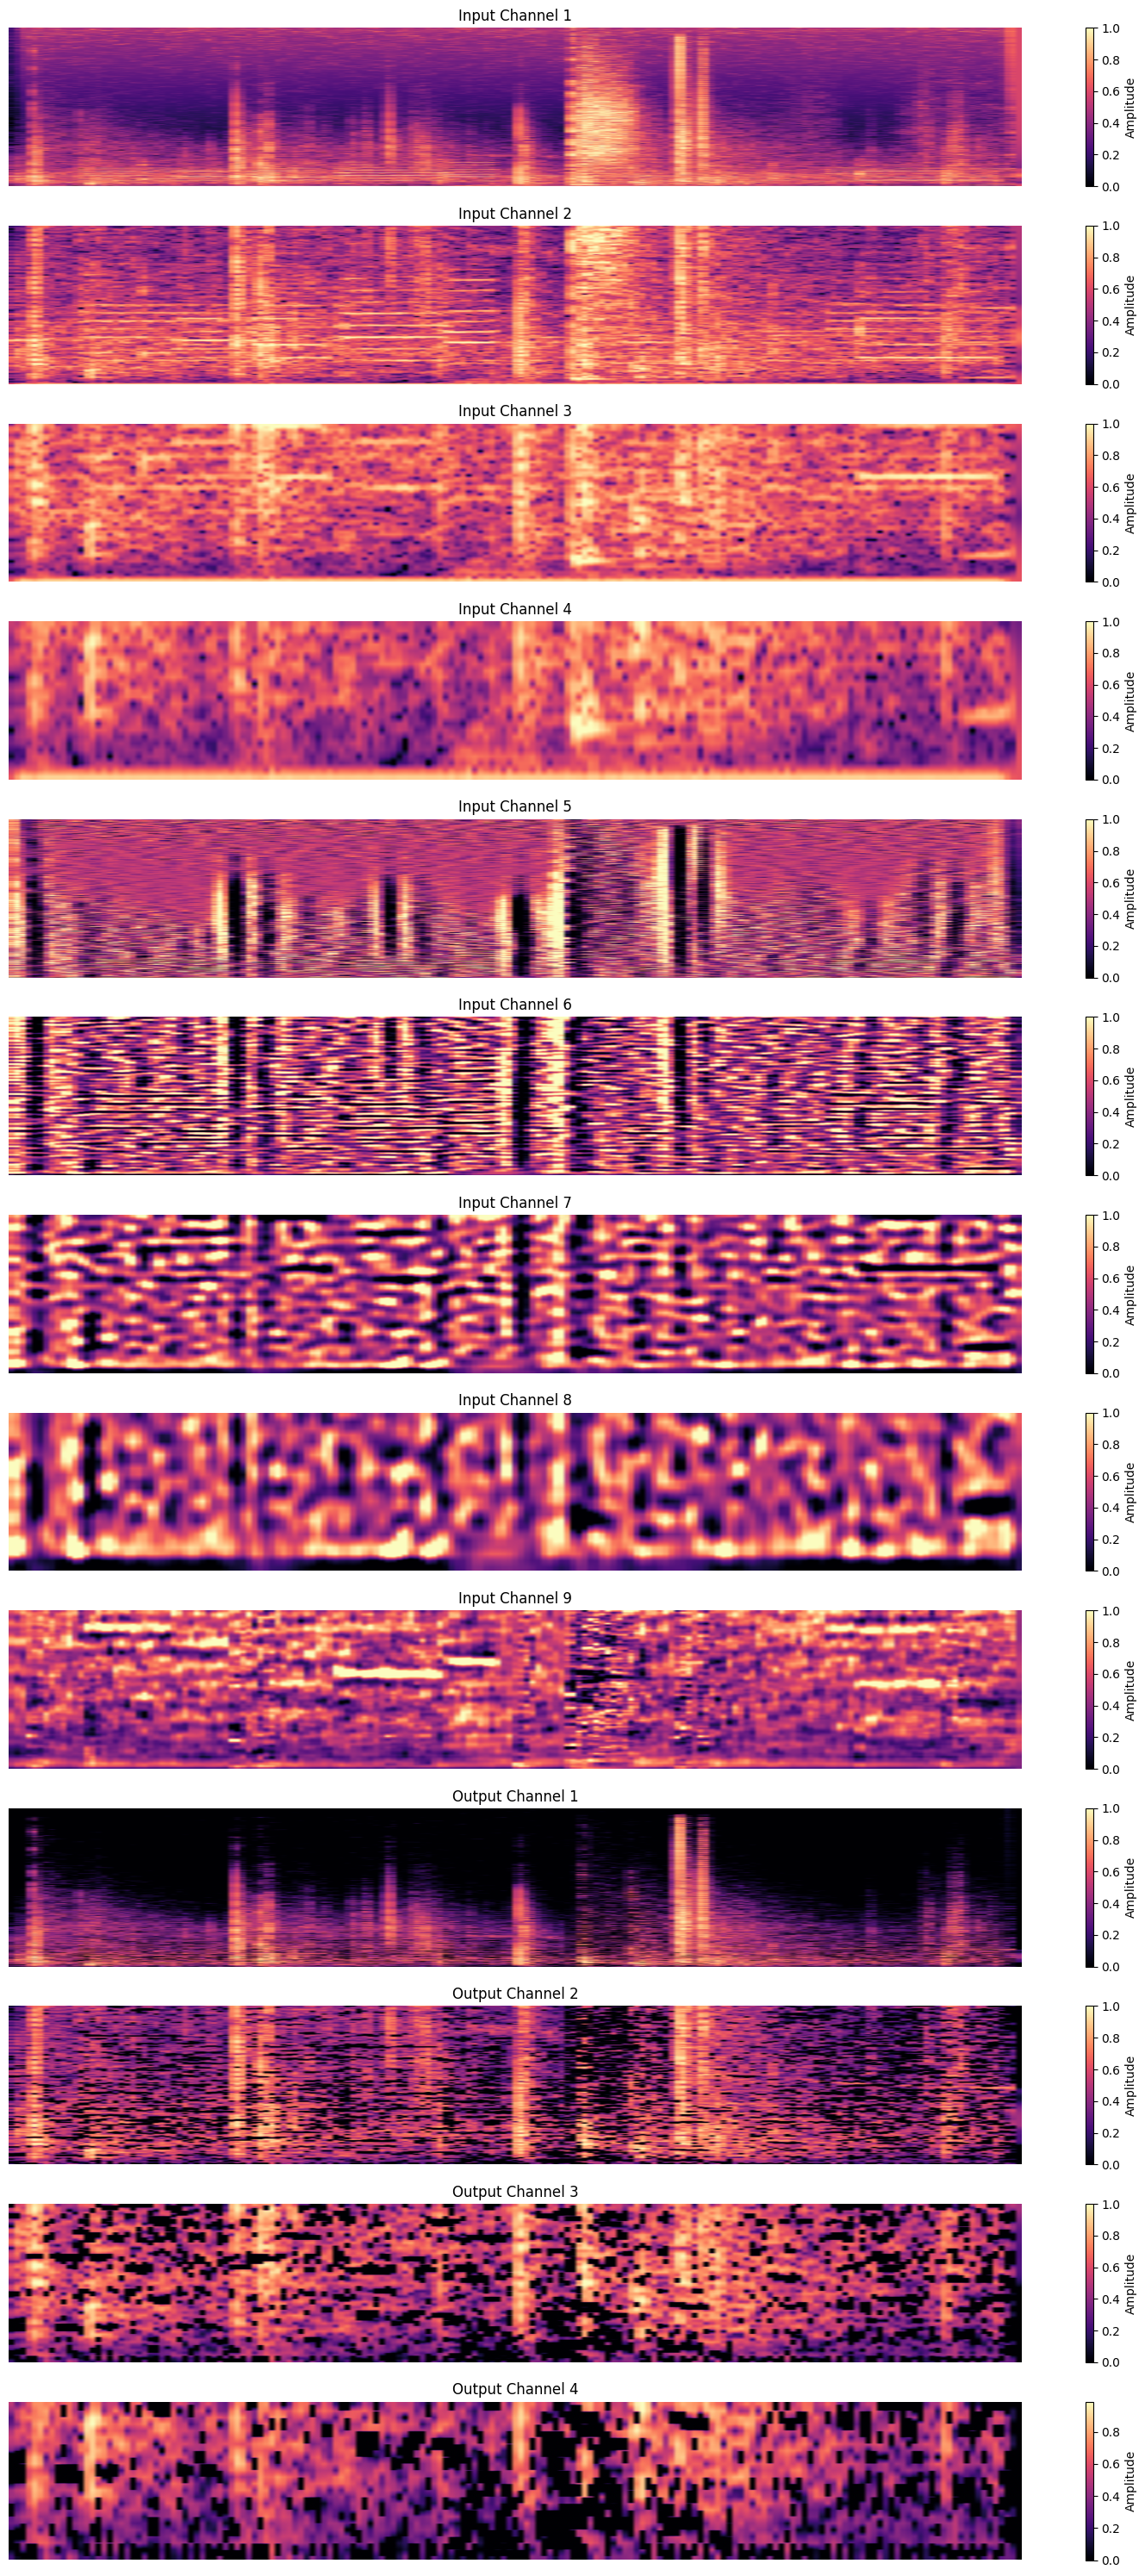

In [14]:
if LOAD_DATA:
  import matplotlib.pyplot as plt
  import torch
  import numpy as np

  # Fetch a sample
  input_tensor, output_tensor, metadata = train_loader.train_dataset[275]

  print(metadata['snr_db'])

  # Convert to NumPy for plotting
  input_array = np.clip(input_tensor.numpy(), 0, 1)
  output_array = np.clip(output_tensor.numpy(), 0, 1)

  # Number of input channels
  num_channels_in = input_array.shape[0]
  num_channels_out = output_array.shape[0]

  # Create subplots
  fig, axes = plt.subplots(num_channels_in + num_channels_out, 1, figsize=(15, 30))

  # Plot each input channel
  for i in range(num_channels_in):
      input = input_array[i]
      print('Min, Max: ', np.min(input), np.max(input))
      im = axes[i].imshow(input, aspect='auto', cmap='magma')
      axes[i].invert_yaxis()

      axes[i].set_title(f"Input Channel {i+1}")
      axes[i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[i], orientation="vertical")
      cbar.set_label("Amplitude")

    # Plot each input channel
  for i in range(num_channels_out):
      output = output_array[i]
      print('Min, Max: ', np.min(output), np.max(output))
      im = axes[num_channels_in + i].imshow(output, aspect='auto', cmap='magma')
      axes[num_channels_in + i].invert_yaxis()

      axes[num_channels_in + i].set_title(f"Output Channel {i+1}")
      axes[num_channels_in + i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[num_channels_in + i], orientation="vertical")
      cbar.set_label("Amplitude")

  plt.tight_layout()
  plt.show()


## Train Model

In [15]:
from audioautoencoder.loss import *
from audioautoencoder.utils import *

In [16]:
import torch

torch.cuda.empty_cache()

In [17]:
if load:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=eta_min)
  scheduler_loss = False
else:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=eta_min)
  scheduler_loss = False

  #optimizer = None #torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
  #scheduler_loss = False #True

In [18]:
import torch
import gc

def clear_gpu_memory():
    """Clears all allocated GPU memory in PyTorch."""
    torch.cuda.empty_cache()  # Clears cache
    gc.collect()  # Runs Python garbage collector
    for i in range(torch.cuda.device_count()):
        torch.cuda.reset_peak_memory_stats(i)  # Resets peak memory tracking

clear_gpu_memory()

In [19]:
from audioautoencoder.training import *

In [20]:
if train:
  trainer = DenoisingTrainer(
      model=model, noisy_train_loader=train_loader.train_loader, noisy_val_loader=train_loader.val_loader,
      SNRdB=SNRdB, output_path=output_path, epochs=epochs, learning_rate=learning_rate,
      load=load, warm_start=warm_start, train=train, train, verbose=False, accumulation_steps=accumulation_steps, load_path=load_path,
      base_lr=base_lr, max_lr=max_lr, gamma=gamma, optimizer=optimizer, scheduler=scheduler, scheduler_loss=scheduler_loss,
      max_noise=0.01, noise_epochs=5, train_diffusion=train_diffusion
  )
  trainer.train_or_evaluate()
  model = trainer.get_model()

  # I need a flat load model function somewhere, as now I need to define a train loader before I can load a model
  csv_file_path = output_path + "training_log.csv"
  plot_training_log(csv_file_path)

Training on device: cpu
Epoch 1, Current Learning Rate: [0.001]


Training:   0%|          | 0/138 [00:00<?, ?batch/s]

New kl loss beta: 0.0
Noise Level:  0.01


Training:   0%|          | 0/138 [00:02<?, ?batch/s]


IndexError: too many indices for tensor of dimension 1

___